<center><a href="https://www.pieriantraining.com/" ><img src="PTCenteredPurple.png" alt="Pierian Training Logo" /></a></center>


# LLM Fine Tuning

In this notebook we'll walk through the process of fine-tuning one of OpenAI's advanced language models on the [MTSamples](https://mtsamples.com/) dataset. The objective is to enhance the model's proficiency in understanding and generating medical content, making it a valuable tool for healthcare professionals, researchers, and students.

Large language models have shown remarkable abilities to understand, generate, and even creatively engage with a wide range of topics. However, when it comes to medical data and other specialized fields, their proficiency can sometimes be less than optimal due to a variety of reasons:

1. Training Data:<br />
LLMs are trained on unimaginable amount of data from the internet. However, due to e.g. HIPAA privacy regulations, the percentage of high-quality,  medical content on the internet is limited compared to other topics. Therefore, LLMs might not have been exposed to as much specialized medical knowledge during their training.

2. Complexity and Specificity:<br />
Medical data and literature often contain highly specialized terms, concepts, and relationships that are complex. Proficiency in this domain requires not only an understanding of the terms but also the context in which they are used. LLMs can sometimes misinterpret or oversimplify these intricate concepts.

3. Generalization vs. Specialization:<br />
Large Language Models are designed to be generalists, capable of addressing a wide range of topics. While they can generate information on many subjects, they might not always match the depth and accuracy of a model or system specifically designed and trained for medical data.


**To this end, the goal of this lecture is to fine tune {INSERT MODEL HERE} on medical reports in order to classify medical reports based on the underlying specialty !**

## Objectives:

1. **Exploring the MTSamples Dataset:**<br />
    - We'll begin by exploring the dataset and its structure.
2. **Preprocessing:** 
    - To prepare for the fine-tuning process, we need to process the dataset into a specific format
3. **Fine-Tuning Process:** 
    - A step-by-step guide to fine-tuning the model, including setting up the right hyperparameters.
4. **Evaluation:** 
    - After training, we'll evaluate our fine-tuned model's performance on medical transcriptions.
5. **Applications & Use-Cases:** 
    - Brief insights into the myriad of ways this fine-tuned model can be utilized in the healthcare domain.


https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/code

# Exploring the MTSamples Dataset

The dataset was originally obtained from [kaggle](https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/).
Note that we already removed all unncessary columns


In [1]:
import pandas as pd

In [2]:
medical_reports = pd.read_csv("reports.csv")

### Inspect the dataset

In [3]:
medical_reports.head()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


We can see, that the dataset consists of the patient's report and the corresponding medical specialty

### Preprocessing
Let's check the dataset info

In [4]:
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


We can see that the number of medical_specialty differs from the reports. Let's remove the entries with the missing reports

In [5]:
# Dropping rows where 'report' is missing
medical_reports.dropna(subset=['report'], inplace=True)
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


### Train-Test Split
Before we inspect the dataset in more detail, let's at first create the train-val-test split
Let's select 5 samples out of each class for validation and test data

In [6]:
grouped_data = medical_reports.groupby("medical_specialty").sample(110, random_state=42) # Sample 110 items from each class

val_test_data = grouped_data.groupby("medical_specialty").sample(10, random_state=42)  # sample 10 items from the above data
val = val_test_data.groupby("medical_specialty").head(5) # Take the first 5 of each class
test = val_test_data.groupby("medical_specialty").tail(5) # Take the last 5 of each class

train = grouped_data[~grouped_data.index.isin(val_test_data.index)] # Take the remaining ones for training

### Dataset Statistics
Let's explore the dataset to provide some basic statistics

In [7]:
# 1. Number of unique medical specialties
print(f"Number of unique medical specialties: {train['medical_specialty'].nunique()}")

# 2. Distribution of reports across different medical specialties
print("\nDistribution of reports across medical specialties:")
print(train['medical_specialty'].value_counts())


Number of unique medical specialties: 5

Distribution of reports across medical specialties:
Cardiovascular / Pulmonary    100
Gastroenterology              100
Neurology                     100
Radiology                     100
Surgery                       100
Name: medical_specialty, dtype: int64


In [8]:
# 3. Average, minimum, and maximum report length (in tokens, not words).
# This is important due to token limitations and also to estimate the price.
# Let's calculate the tokens for OpenAI's cheapest model, babbage-002
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string.
    (https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken)"""
    encoding = tiktoken.get_encoding("cl100k_base")  # encoding for currently all models
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [9]:
report_lengths = train['report'].apply(lambda x: num_tokens_from_string(x))
avg_report_length = report_lengths.mean()
min_report_length = report_lengths.min()
max_report_length = report_lengths.max()
report_length_sum = report_lengths.sum()

print(f"Average report length: {avg_report_length:.2f} tokens")
print(f"Minimum report length: {min_report_length} tokens")
print(f"Maximum report length: {max_report_length} tokens")
print(f"# The training dataset consists of: {report_length_sum} tokens")


Average report length: 674.79 tokens
Minimum report length: 14 tokens
Maximum report length: 3701 tokens
# The training dataset consists of: 337394 tokens


In [10]:
price_model = 0.0080   # Price for gpt-3.5-turbo per 1K tokens
model = "gpt-3.5-turbo"
price_per_epoch = (report_length_sum / 1000) * price_model 
print(f"Fine-tuning of {model} costs ~ ${price_per_epoch:.2f} per epoch") 

Fine-tuning of gpt-3.5-turbo costs ~ $2.70 per epoch


### Fine-tuning data formatting

We can now rearrange the dataset into the necessary format in order to start the fine tuning job.
The format is as follows:

```json
{"messages": [{"role": "system", "content": "Given the medical description report, classify it into one of these categories: [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"}, {"role": "user", "content": "Medical Report"}, {"role": "assistant", "content": "The medical specialty assigned to this report"}]}
```

In [11]:
system_prompt = "Given the medical description report, classify it into one of these categories: " + \
                 "[Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"

In [12]:
sample_prompt = {"messages": [{"role": "system", "content": system_prompt},
                              {"role": "user", "content": train["report"].iloc[0]},
                              {"role": "assistant", "content": train["medical_specialty"].iloc[0]}]}


In [13]:
print(sample_prompt)

{'messages': [{'role': 'system', 'content': 'Given the medical description report, classify it into one of these categories: [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]'}, {'role': 'user', 'content': "PREOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,POSTOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,ANESTHESIA:,  General.,PROCEDURE:,  Placement of left subclavian 4-French Broviac catheter.,INDICATIONS:  ,The patient is a toddler admitted with a limp and back pain, who was eventually found on bone scan and septic workup to have probable osteomyelitis of the lumbar spine at disk areas.  The patient needs prolonged IV antibiotic therapy, but attempt at a PICC line failed.  She has exhausted most of her easy peripheral IV access routes and referral was made to the Pediatric Surgery Service for Broviac placement.  I met with the patient's mom.  With the help o

Let's write a script that converts the dataframe into this format and stores everything as a json

In [14]:
def df_to_format(df):
    formatted_data = []
    
    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        entry = {"messages": [{"role": "system", "content": system_prompt},
                              {"role": "user", "content": row["report"]},
                              {"role": "assistant", "content": row["medical_specialty"]}]}

        formatted_data.append(entry)

    return formatted_data


In [15]:
data = df_to_format(train)

In [16]:
print(data[100])

{'messages': [{'role': 'system', 'content': 'Given the medical description report, classify it into one of these categories: [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]'}, {'role': 'user', 'content': 'PROCEDURE:, Esophagogastroduodenoscopy with biopsy and snare polypectomy.,INDICATION FOR THE PROCEDURE:, Iron-deficiency anemia.,MEDICATIONS:, MAC.,The risks of the procedure were made aware to the patient and consisted of medication reaction, bleeding, perforation, and aspiration.,PROCEDURE:, After informed consent and appropriate sedation, the upper endoscope was inserted into the oropharynx down into the stomach and beyond the pylorus and the second portion of the duodenum. The duodenal mucosa was completely normal. The pylorus was normal. In the stomach, there was evidence of diffuse atrophic-appearing nodular gastritis. Multiple biopsies were obtained. There also was a 1.5-cm adenomatous appearing polyp along the greater curvature at the junction of 

Let's dump this list of dictionaries into the training file

In [17]:
import json
with open('fine_tuning_data.jsonl', 'w') as f:
    for entry in data:
        f.write(json.dumps(entry))
        f.write("\n")
        
        
    


### Val Data
Let's perform the same operation for the validation data

In [18]:
val_data = df_to_format(val)

In [19]:
import json
with open('fine_tuning_data_val.jsonl', 'w') as f:
    for entry in val_data:
        f.write(json.dumps(entry))
        f.write("\n")
        
        
    


## Sanity Checks
Before starting the training process, we should check if any input exceeds the maximum of 4096 tokens. Additionally, let's make sure that there are no empty reports

In [20]:
def check_num_tokens(prompt):
    prompt_text = " ".join([content["content"] for content in element["messages"]])
    tokens = num_tokens_from_string(prompt_text)
    if tokens > 4000: # according to https://platform.openai.com/docs/guides/fine-tuning/token-limits
        print(f"Prompt {prompt} exceeds token limit!")
        return False
    return True
    
def check_prompt(prompt):
    
    if len(prompt["messages"][1]["content"]):
        if len(prompt["messages"][2]["content"]):
            return True
    print(f"Prompt {prompt} is missing data!")

    return False


We can now read the jsonl file and check each entry

In [21]:
with open('fine_tuning_data.jsonl', 'r') as f:
    dataset = [json.loads(line) for line in f]


In [22]:
for element in dataset:
    assert check_num_tokens(element) and check_prompt(element)
        

In [23]:
with open('fine_tuning_data_val.jsonl', 'r') as f:
    dataset = [json.loads(line) for line in f]

for element in dataset:
    assert check_num_tokens(element) and check_prompt(element)
        

Great! There are no violations!

## Training
Now it's time to start the training process

In [24]:
import os
import openai
openai.api_key = ""
openai.organization = "org-FWKNS6AR0jCIQjL9hXW7WLCS"

At first we need to upload the fine-tuning data to openai using the **File.create** [method](https://platform.openai.com/docs/api-reference/files/create) to which you need to pass the binary file object and a purpose (fine-tuning in our case). If you pass "fine-tuning" as purpose, openai validates the file structure once more

In [153]:
file_upload_response = openai.File.create(
  file=open("fine_tuning_data.jsonl", "rb"),
  purpose='fine-tune'
)


In [154]:
file_upload_response

<File file id=file-Nakt5J3kApTIHZB7dUyiTL9R at 0x7fe08c0f1ea0> JSON: {
  "object": "file",
  "id": "file-Nakt5J3kApTIHZB7dUyiTL9R",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 1543622,
  "created_at": 1699471986,
  "status": "processed",
  "status_details": null
}

Uploading the File object might take a while.
You can navigate to https://platform.openai.com/files to check if your file has been processed.
Alternativeley, you can use **File.retrieve(file_id)**


In [155]:
openai.File.retrieve(file_upload_response["id"])

<File file id=file-Nakt5J3kApTIHZB7dUyiTL9R at 0x7fe08cc445e0> JSON: {
  "object": "file",
  "id": "file-Nakt5J3kApTIHZB7dUyiTL9R",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 1543622,
  "created_at": 1699471986,
  "status": "processed",
  "status_details": null
}

Perform the same steps for the val data

In [156]:
file_upload_response_val = openai.File.create(
  file=open("fine_tuning_data_val.jsonl", "rb"),
  purpose='fine-tune'
)


In [157]:
openai.File.retrieve(file_upload_response_val["id"])

<File file id=file-YQeOtRlpNEZk4JGRitMSQXma at 0x7fe08c0fa040> JSON: {
  "object": "file",
  "id": "file-YQeOtRlpNEZk4JGRitMSQXma",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 101484,
  "created_at": 1699472003,
  "status": "processed",
  "status_details": null
}

Now it's time to start the [training process](https://platform.openai.com/docs/api-reference/fine-tuning/create):

To start the training routine we can call FineTuningJob.create which accepts the following arguments:
- object
- id
- model
- created_at
- fine_tuned_model
- organization_id
- result_files
- status
- validation_file
- training_file

Only *model* and *training_file* are required, the remaining arguments are optional.
You can specify the number of epochs using the hyperparameter argument. Currently *n_epochs* is the only hyperparameter available.


In [158]:
fine_tuning_response = openai.FineTuningJob.create(training_file=file_upload_response["id"],
                            model="gpt-3.5-turbo",
                            hyperparameters={"n_epochs": 1},
                            validation_file = file_upload_response_val["id"])

To obtain the log, you can use *FineTuningJob.list_events* to which you pass the job id and a limit if you want 

In [159]:
fine_tuning_response["id"]

'ftjob-0ZB6FD70DnweK1F6euj03SNg'

In [160]:
openai.FineTuningJob.list_events(id="ftjob-0ZB6FD70DnweK1F6euj03SNg", limit=10)


<OpenAIObject list at 0x7fe08d39f090> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-rX27MvxjrDPJc9uCp7DAQL3G",
      "created_at": 1699472034,
      "level": "info",
      "message": "Validating training file: file-Nakt5J3kApTIHZB7dUyiTL9R and validation file: file-YQeOtRlpNEZk4JGRitMSQXma",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-bVW5CDOjFguyqIr7nqUmYegJ",
      "created_at": 1699472034,
      "level": "info",
      "message": "Created fine-tuning job: ftjob-0ZB6FD70DnweK1F6euj03SNg",
      "data": {},
      "type": "message"
    }
  ],
  "has_more": false
}

### Plot losses
We can use *FineTuningJob.list_events* to obtain all event data and plot the training metrics.
Note that if you do not pass a limit, openai will not automatically grab all data. Thus, it's best to pass a large limit

In [26]:
train_event = openai.FineTuningJob.list_events(id="ftjob-0ZB6FD70DnweK1F6euj03SNg", limit=500)

In [27]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for item in train_event["data"]:
    train_data = item["data"]
    if train_data and "train_loss" in train_data:
        
        # As the event list returns the most current event at first, we don't want to append but insert
        train_loss.insert(0, train_data["train_loss"])
        val_loss.insert(0, train_data["valid_loss"])
        train_acc.insert(0, train_data["train_mean_token_accuracy"])
        val_acc.insert(0, train_data["valid_mean_token_accuracy"])


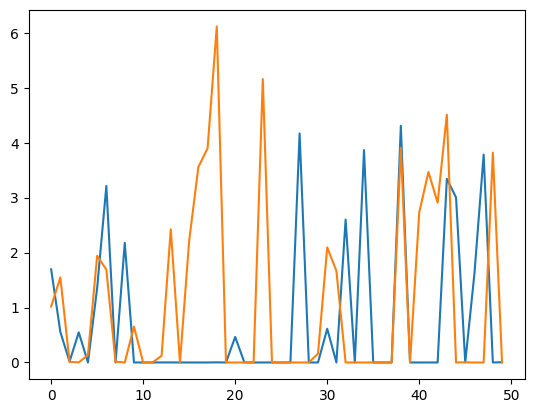

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)

## Application
To use the fine-tuned model, we just need to pass it to *ChatCompletion.create* and proceed as usual.
You can grab the model name either via the openai [fine-tuning dashboard](https://platform.openai.com/finetune/) or using *openai.FineTuningJob.retrieve(id)*

In [25]:
openai.FineTuningJob.retrieve("ftjob-0ZB6FD70DnweK1F6euj03SNg")["fine_tuned_model"]

'ft:gpt-3.5-turbo-0613:pierian-training::8IjdNdPL'

In [26]:
test["report"].iloc[1]

'INDICATIONS: , The patient is a 22-year-old female with past medical history of syncope.  The patient is also complaining of dizziness.  She was referred here by Dr. X for tilt table.,TECHNIQUE: , Risks and benefits explained to the patient.  Consent obtained.  She was lying down on her back for 20 minutes and her blood pressure was 111/75 and heart rate 89.  She was standing up on the tilt tablet for 20 minutes and her heart rate went up to 127 and blood pressure was still in 120/80.  Then, the patient received sublingual nitroglycerin 0.4 mg.  The patient felt dizzy at that time and heart rate was in the 120 and blood pressure was 110/50.  The patient felt nauseous and felt hot at that time.  She did not pass out.,COMPLICATIONS:,  None.,Tilt table was then terminated.,SUMMARY:,  Positive tilt table for vasovagal syncope with significant increase of heart rate with minimal decrease of blood pressure.,RECOMMENDATIONS: , I recommend followup in the office in one week and she will need 

In [27]:
completion = openai.ChatCompletion.create(
    model = "ft:gpt-3.5-turbo-0613:pierian-training::8IjdNdPL", 
  messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": test["report"].iloc[1]}
  ]
)
print(completion.choices[0].message)


{
  "role": "assistant",
  "content": "Cardiovascular / Pulmonary"
}


In [28]:
test["medical_specialty"].iloc[1]

'Cardiovascular / Pulmonary'

Let's loop over the test data and count how many reports are classified correctly

In [29]:
def classify_report(report):
    completion = openai.ChatCompletion.create(
                    model = "ft:gpt-3.5-turbo-0613:pierian-training::8IjdNdPL", 
                    # model = "gpt-3.5-turbo",
                    messages=[
                            {"role": "system", "content": system_prompt},
                            {"role": "user", "content": report}
                          ]
                        )
    return completion


In [30]:
test

,medical_specialty,report
2016,Cardiovascular / Pulmonary,"CLINICAL INDICATION:, Chest pain.,INTERPRETAT..."
1833,Cardiovascular / Pulmonary,"INDICATIONS: , The patient is a 22-year-old fe..."
1932,Cardiovascular / Pulmonary,"REASON FOR CONSULTATION: , Loculated left effu..."
1949,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSIS:, Right middle lobe lu..."
1847,Cardiovascular / Pulmonary,"POSTOPERATIVE DIAGNOSIS: , Type 4 thoracoabdom..."
1639,Gastroenterology,"PREOPERATIVE DIAGNOSIS:,1. Cholelithiasis.,2...."
1735,Gastroenterology,"EXAM: , CT of the abdomen and pelvis without c..."
1781,Gastroenterology,"REASON FOR CONSULTATION: , I was asked by Dr. ..."
1670,Gastroenterology,"DIAGNOSIS ON ADMISSION: , Gastrointestinal ble..."
1776,Gastroenterology,"PROCEDURE:, Colonoscopy.,PREOPERATIVE DIAGNOS..."


In [31]:
predicted_classes = []
ground_truth_classes = []
for line in test.iterrows():
    report, specialty = line[1]["report"], line[1]["medical_specialty"]
    ground_truth_classes.append(specialty.strip())  # in case of any trailing
    prediction = classify_report(report)
    predicted_classes.append(prediction.choices[0].message["content"].strip())
    
    

In [32]:
import numpy as np

In [33]:
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

0.68

In [38]:
predicted_classes

['Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Surgery',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Neurology',
 'Neurology',
 'Neurology',
 'Neurology',
 'Neurology',
 'Radiology',
 'Gastroenterology',
 'Neurology',
 'Cardiovascular / Pulmonary',
 'Neurology',
 'Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Surgery',
 'Surgery',
 'Cardiovascular / Pulmonary']

In [117]:
ground_truth_classes

['Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Neurology',
 'Neurology',
 'Neurology',
 'Neurology',
 'Neurology',
 'Radiology',
 'Radiology',
 'Radiology',
 'Radiology',
 'Radiology',
 'Surgery',
 'Surgery',
 'Surgery',
 'Surgery',
 'Surgery']

### Comparison to gpt-3.5-turbo
Let's compare how our model works compared to the standard model

In [42]:
import time
from tqdm.notebook import tqdm

def classify_report_baseline(report):
    try:
        completion = openai.ChatCompletion.create(
                        model = "gpt-3.5-turbo",
                        messages=[
                                {"role": "system", "content": system_prompt},
                                {"role": "user", "content": report}
                              ],
                        temperature=0
                            )
    except openai.error.APIConnectionError:  # To retry if openai loses the connection
        time.sleep(10)
        completion = openai.ChatCompletion.create(
                model = "gpt-3.5-turbo",
                messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": report}
                      ],
                temperature=0
                    )

    return completion


In [43]:
predicted_classes = []
ground_truth_classes = []
for line in tqdm(test.iterrows()):
    report, specialty = line[1]["report"], line[1]["medical_specialty"]
    ground_truth_classes.append(specialty.strip())  # in case of any trailing
    prediction = classify_report_baseline(report)
    predicted_classes.append(prediction.choices[0].message["content"].strip())
    
    

0it [00:00, ?it/s]

In [44]:
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

0.56